### Master Project: Build a Research Agent with LangGraph, GPT-4o, RAG, Pinecone, ArXiv, and Google SerpAPI (Real Time Google Search API)

---------------------------------------------------------------------------------------------

### Extracting Data from ArXiv into Pandas DataFrame and Saving it as JSON

In [ ]:
import requests
from pathlib import Path
import pandas as pd
import json
import xml.etree.ElementTree as ET  # parsing and manipulating XML data

# Namespace for ArXiv's Atom-based XML Format.
ARXIV_NAMESPACE = "{http://www.w3.org/2005/Atom}"


# Defining a function
def extract_from_arxiv(
    search_query: str = "cat:cs.AI",  ###by default Computer Science AI
    max_results: int = 100,
    json_file_path: str = "files/arxiv_dataset.json",  ###saves it as JSON format
):
    """
    Fetches papers from the ArXiv API based on a search query, saves them as JSON,
    and returns a pandas DataFrame.

    Args:
        search_query (str): The search query for ArXiv (by default is 'cat:cs.AI').
        max_results (int): The maximum number of results to retrieve (default is 100).
        json_file_path (str): File path where JSON data will be saved.

    Returns:
        pd.DataFrame: DataFrame containing the extracted paper information.
    """

    ## Construct the json_file_path if doesn't exist
    json_data_path = Path("files/")
    if json_data_path.is_dir():
        print(f"{json_data_path} already exists")
    else:
        print(f"{json_data_path} doesn't exists, creating new....")
        json_data_path.mkdir(parents=True, exist_ok=True)

    ## URL Constructor: Construct the URL for the API Request.
    url = f"http://export.arxiv.org/api/query?search_query={search_query}&max_results={max_results}"

    ## Send a GET request to the Arxiv API
    response = requests.get(
        url
    )  ### This will return the XML data for the requested results

    ## Parse the XML Response
    root = ET.fromstring(
        response.content
    )  ### ET: Element Tree to navigate the XML structure and navigate the data we need

    papers = []  ### To store all the extracted paper data

    ## Loop through each "entry" in the XML, representing a SINGLE PAPER. For each Paper, we are extracting Title, Summary, Author, URL
    for entry in root.findall(f"{ARXIV_NAMESPACE}entry"):
        title = entry.find(f"{ARXIV_NAMESPACE}title").text.strip()
        summary = entry.find(f"{ARXIV_NAMESPACE}summary").text.strip()

        ### Get the authors of the paper
        author_elements = entry.findall(f"{ARXIV_NAMESPACE}author")
        authors = [
            author.find(f"{ARXIV_NAMESPACE}name").text for author in author_elements
        ]

        ### Get the paper's URL
        paper_url = entry.find(
            f"{ARXIV_NAMESPACE}id"
        ).text  ### Later we can use this URL for PDF, chunking and embedding
        arxiv_id = paper_url.split("/")[
            -1
        ]  ### Extracting the Arxiv ID, which is the last part of the paper_url

        ### Check for the PDF link, from the paper_URL
        pdf_link = next(
            (
                link.attrib["href"]
                for link in entry.findall(f"{ARXIV_NAMESPACE}link")
                if link.attrib.get("title") == "pdf"
            ),
            None,
        )

        papers.append(
            {
                "title": title,
                "summary": summary,
                "authors": authors,
                "arxiv_id": arxiv_id,
                "url": paper_url,
                "pdf_link": pdf_link,
            }
        )

    ## Convert list (papers) into DataFrame
    df = pd.DataFrame(papers)

    ## Save the DataFrame to a JSON file
    with open(json_file_path, "w", encoding="utf-8") as f:
        json.dump(papers, f, ensure_ascii=False, indent=4)
        print(f"Data Saved to {json_file_path}")

    return df

In [2]:
# Let's test the function

df = extract_from_arxiv(max_results=20)

files already exists
Data Saved to files/arxiv_dataset.json


In [ ]:
# To Read the JSON File
import json

file_name = "files/arxiv_dataset.json"
with open(file_name, "r") as file:
    data = json.load(file)

print(data)

[{'title': 'Dynamic Backtracking', 'summary': 'Because of their occasional need to return to shallow points in a search\ntree, existing backtracking methods can sometimes erase meaningful progress\ntoward solving a search problem. In this paper, we present a method by which\nbacktrack points can be moved deeper in the search space, thereby avoiding this\ndifficulty. The technique developed is a variant of dependency-directed\nbacktracking that uses only polynomial space while still providing useful\ncontrol information and retaining the completeness guarantees provided by\nearlier approaches.', 'authors': ['M. L. Ginsberg'], 'arxiv_id': '9308101v1', 'url': 'http://arxiv.org/abs/cs/9308101v1', 'pdf_link': 'http://arxiv.org/pdf/cs/9308101v1'}, {'title': 'A Market-Oriented Programming Environment and its Application to\n  Distributed Multicommodity Flow Problems', 'summary': 'Market price systems constitute a well-understood class of mechanisms that\nunder certain conditions provide effec

In [ ]:
# To Read the DF
print(f"\n Shape of the DataFrame: {df.shape}\n")
df.head()

## to check the random rows of the dataframe
# df.sample()


 Shape of the DataFrame: (20, 6)



,title,summary,authors,arxiv_id,url,pdf_link
0,Dynamic Backtracking,Because of their occasional need to return to ...,[M. L. Ginsberg],9308101v1,http://arxiv.org/abs/cs/9308101v1,http://arxiv.org/pdf/cs/9308101v1
1,A Market-Oriented Programming Environment and ...,Market price systems constitute a well-underst...,[M. P. Wellman],9308102v1,http://arxiv.org/abs/cs/9308102v1,http://arxiv.org/pdf/cs/9308102v1
2,An Empirical Analysis of Search in GSAT,We describe an extensive study of search in GS...,"[I. P. Gent, T. Walsh]",9309101v1,http://arxiv.org/abs/cs/9309101v1,http://arxiv.org/pdf/cs/9309101v1
3,The Difficulties of Learning Logic Programs wi...,As real logic programmers normally use cut (!)...,"[F. Bergadano, D. Gunetti, U. Trinchero]",9311101v1,http://arxiv.org/abs/cs/9311101v1,http://arxiv.org/pdf/cs/9311101v1
4,Software Agents: Completing Patterns and Const...,To support the goal of allowing users to recor...,"[J. C. Schlimmer, L. A. Hermens]",9311102v1,http://arxiv.org/abs/cs/9311102v1,http://arxiv.org/pdf/cs/9311102v1


#### Downloading the Research Paper - Downloading the 20 Research papers that we generated above, using the coloumn PDF Link and saving it to files.

In [ ]:
import pandas as pd
import requests
import os
from pathlib import Path


# Defining the Function
def download_pdf(df=df, download_folder: str = "files"):
    """
    Downloads PDFs from URLs listed in the DataFrame and saves them to a specified folder.
    The file names are stored in a new column 'pdf_file_name' in the DataFrame.

    Args:
        df (DataFrame): DataFrame containing a "pdf_link" column with the URLs to download.
        download_folder: Path to the folder where PDFs will be saved (default is 'files').

    Returns:
        pd.DataFrame: The original DataFrame with an additional "pdf_file_name" column containing
                      the paths of the downloaded PDF files or None if the download failed.
    """

    if not os.path.exists(download_folder):
        print(f"Download Folder Doesn't Exists, Creating Folder {download_folder} ....")
        os.makedirs(download_folder)
        print("Folder Created")
    else:
        print(f"Downlad Folder Already Exists!")

    pdf_file_names = []

    ## Loop through each row to download the PDFs
    for index, row in df.iterrows():
        pdf_link = row["pdf_link"]

        try:
            response = requests.get(pdf_link)
            response.raise_for_status()

            file_name = os.path.join(download_folder, pdf_link.split("/")[-1]) + ".pdf"
            pdf_file_names.append(file_name)

            ## Save the downloaded PDF
            with open(file_name, "wb") as f:
                f.write(response.content)

            print(f"PDF downloaded successfully and saved as {file_name}")

        except requests.exceptions.RequestException as e:
            print(f"Failed to download the PDF: {e}")
            pdf_file_names.append(None)

    df["pdf_file_name"] = pdf_file_names

    return df

In [6]:
# Test the function

df = download_pdf(df=df)

Downlad Folder Already Exists!
PDF downloaded successfully and saved as files/9308101v1.pdf
PDF downloaded successfully and saved as files/9308102v1.pdf
PDF downloaded successfully and saved as files/9309101v1.pdf
PDF downloaded successfully and saved as files/9311101v1.pdf
PDF downloaded successfully and saved as files/9311102v1.pdf
PDF downloaded successfully and saved as files/9312101v1.pdf
PDF downloaded successfully and saved as files/9401101v1.pdf
PDF downloaded successfully and saved as files/9402101v1.pdf
PDF downloaded successfully and saved as files/9402102v1.pdf
PDF downloaded successfully and saved as files/9402103v1.pdf
PDF downloaded successfully and saved as files/9403101v1.pdf
PDF downloaded successfully and saved as files/9406101v1.pdf
PDF downloaded successfully and saved as files/9406102v1.pdf
PDF downloaded successfully and saved as files/9408101v1.pdf
PDF downloaded successfully and saved as files/9408102v1.pdf
PDF downloaded successfully and saved as files/9408103

In [ ]:
df.head()

,title,summary,authors,arxiv_id,url,pdf_link,pdf_file_name
0,Dynamic Backtracking,Because of their occasional need to return to ...,[M. L. Ginsberg],9308101v1,http://arxiv.org/abs/cs/9308101v1,http://arxiv.org/pdf/cs/9308101v1,files/9308101v1.pdf
1,A Market-Oriented Programming Environment and ...,Market price systems constitute a well-underst...,[M. P. Wellman],9308102v1,http://arxiv.org/abs/cs/9308102v1,http://arxiv.org/pdf/cs/9308102v1,files/9308102v1.pdf
2,An Empirical Analysis of Search in GSAT,We describe an extensive study of search in GS...,"[I. P. Gent, T. Walsh]",9309101v1,http://arxiv.org/abs/cs/9309101v1,http://arxiv.org/pdf/cs/9309101v1,files/9309101v1.pdf
3,The Difficulties of Learning Logic Programs wi...,As real logic programmers normally use cut (!)...,"[F. Bergadano, D. Gunetti, U. Trinchero]",9311101v1,http://arxiv.org/abs/cs/9311101v1,http://arxiv.org/pdf/cs/9311101v1,files/9311101v1.pdf
4,Software Agents: Completing Patterns and Const...,To support the goal of allowing users to recor...,"[J. C. Schlimmer, L. A. Hermens]",9311102v1,http://arxiv.org/abs/cs/9311102v1,http://arxiv.org/pdf/cs/9311102v1,files/9311102v1.pdf


In [8]:
## To save the DataFrame for re-usability
df.to_csv("research_papers_dataframe.csv")

### Loading and Splitting PDF Files into Chunks, Expanding the DataFrame

In [ ]:
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Defining the Function


def load_and_chunk_pdf(pdf_file_name, chunk_size: int = 512):
    """
    Load a PDF File and splits its content into chunks of a specified size.

    Arg:
        file (str): Path to the PDF file to be loaded.
        chunk_size (int): The max size of each chunk in characters (default is 512).

    Returns:
        List[Documents]: A list of document chunks.
    """

    print(f"Loading and Splitting into chunks: {pdf_file_name}")

    ## Load the content of the PDF
    loader = PyPDFLoader(pdf_file_name)
    data = loader.load()

    ## Split the content into chunks with slight overlap to preserve context
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size, chunk_overlap=64
    )
    chunks = text_splitter.split_documents(data)

    return chunks

In [ ]:
def expand_df(df):
    """
    Expands each row in the DataFrame by splitting PDF documents into chunks.

    Args:
        df (pd.DataFrame): DataFrame containing 'pdf_file_name', 'arxiv_id', 'title', 'summary',
                            'authors', and 'url' columns.

    Returns:
        pd.DataFrame: A new DataFrame where each row represents a chunk of the original document,
                      with additional metadata such as chunk identifiers and relationships to adjacent
                      chunks.
    """

    expanded_rows = []  # List to store expanded rows with chunk information

    ## loop through each row in the DataFrame
    for idx, row in df.iterrows():
        try:
            chunks = load_and_chunk_pdf(row["pdf_file_name"])
        except Exception as e:
            print(
                f"Error processing file {row['pdf_file_name']} or extension not supported"
            )

        ### Loop over the chunks and construct a new DataFrame row for each
        for i, chunk in enumerate(chunks):
            prechunk_id = i - 1 if i > 0 else ""  # Preceeding chunk ID
            postchunk_id = i + 1 if i < len(chunks) - 1 else ""  # Following chunk ID

            expanded_rows.append(
                {
                    "id": f"{row['arxiv_id']}#{i}",  # unique chunk indentifier
                    "title": row["title"],
                    "summary": row["summary"],
                    "authors": row["authors"],
                    "arxiv_id": row["arxiv_id"],
                    "url": row["url"],
                    "chunk": chunk.page_content,  # Text content of the chunk
                    "prechunk_id": (
                        "" if i == 0 else f"{row['arxiv_id']}#{prechunk_id}"
                    ),  # Previous chunk ID
                    "postchunk_id": (
                        ""
                        if i == len(chunks) - 1
                        else f"{row['arxiv_id']}#{postchunk_id}"
                    ),  # Next chunk ID
                }
            )

    # Return a new expanded DataFrame
    return pd.DataFrame(expanded_rows)

In [13]:
expanded_df = expand_df(df)

Loading and Splitting into chunks: files/9308101v1.pdf
Loading and Splitting into chunks: files/9308102v1.pdf
Loading and Splitting into chunks: files/9309101v1.pdf
Loading and Splitting into chunks: files/9311101v1.pdf
Loading and Splitting into chunks: files/9311102v1.pdf
Loading and Splitting into chunks: files/9312101v1.pdf
Loading and Splitting into chunks: files/9401101v1.pdf
Loading and Splitting into chunks: files/9402101v1.pdf
Loading and Splitting into chunks: files/9402102v1.pdf
Loading and Splitting into chunks: files/9402103v1.pdf
Loading and Splitting into chunks: files/9403101v1.pdf
Loading and Splitting into chunks: files/9406101v1.pdf
Loading and Splitting into chunks: files/9406102v1.pdf
Loading and Splitting into chunks: files/9408101v1.pdf
Loading and Splitting into chunks: files/9408102v1.pdf
Loading and Splitting into chunks: files/9408103v1.pdf
Loading and Splitting into chunks: files/9409101v1.pdf
Loading and Splitting into chunks: files/9412101v1.pdf
Loading an

In [14]:
expanded_df.head()

,id,title,summary,authors,arxiv_id,url,chunk,prechunk_id,postchunk_id
0,9308101v1#0,Dynamic Backtracking,Because of their occasional need to return to ...,[M. L. Ginsberg],9308101v1,http://arxiv.org/abs/cs/9308101v1,Journal of Arti/ cial In telligence Researc h ...,,9308101v1#1
1,9308101v1#1,Dynamic Backtracking,Because of their occasional need to return to ...,[M. L. Ginsberg],9308101v1,http://arxiv.org/abs/cs/9308101v1,"problem/. In this pap er/, w e presen t a meth...",9308101v1#0,9308101v1#2
2,9308101v1#2,Dynamic Backtracking,Because of their occasional need to return to ...,[M. L. Ginsberg],9308101v1,http://arxiv.org/abs/cs/9308101v1,b y earlier approac hes/.\n/1/. In tro duction...,9308101v1#1,9308101v1#3
3,9308101v1#3,Dynamic Backtracking,Because of their occasional need to return to ...,[M. L. Ginsberg],9308101v1,http://arxiv.org/abs/cs/9308101v1,remaining problem in t w o/. W e no w b egin t...,9308101v1#2,9308101v1#4
4,9308101v1#4,Dynamic Backtracking,Because of their occasional need to return to ...,[M. L. Ginsberg],9308101v1,http://arxiv.org/abs/cs/9308101v1,there is no p oin t in w asting time completin...,9308101v1#3,9308101v1#5


In [15]:
expanded_df.to_csv("expanded_df.csv")

### Building a Knowledge Base for RAG Systems using Embedding (using Pinecone vector DB and OpenAI Embedding Model API)

In [14]:
# --- Loading ENV file and authenticating with OpenAI API Model ---
import os
import tqdm
from openai import OpenAI
from dotenv import find_dotenv, load_dotenv
from getpass import getpass
from semantic_router.encoders import (
    OpenAIEncoder,
)  ## for converting texts into embeddings using OpenAI Models

## semantic_router is a smart decision making layer for your LLMs and Agents

# --- Load the Environment Variables ---
dotenv_path = find_dotenv()
if not dotenv_path:
    print(".env file not found, falling back to manual input.\n")
else:
    load_dotenv(dotenv_path, override=True)
    print("Loaded environment variable.\n")

# --- Load the API Key safely ---
api_key = os.getenv("OPENAI_API_KEY") or getpass("Enter your OpenAI API Key: ")

# --- Fail early if still missing ---
if not api_key:
    raise ValueError(
        "OPENAI_API_KEY not found. Please set it in your environment variables."
    )

# --- Initialize OpenAI Client and Encoder ---
client = OpenAI(api_key=api_key)
print("OpenAI Client initialized successfully.")

encoder = OpenAIEncoder(name="text-embedding-3-small")
print("OpenAI Encoder initialized (model: text-embedding-3-small, dim: 1536 default).")

Loaded environment variable.

OpenAI Client initialized successfully.
OpenAI Encoder initialized (model: text-embedding-3-small, dim: 1536 default).


In [1]:
# testing the embedding model
## encoder("How are you Viv")

In [ ]:
# checking the first element 'how' dimension from the sentence
dim = len(encoder("How are you Viv")[0])
dim

1536

### Creating a Pinecode Index

In [15]:
import os
from pinecone import Pinecone, ServerlessSpec

# --- Load the API Key ---
api_key = os.getenv("PINECONE_API_KEY") or getpass("Enter your Pinecone API Key: ")

if not api_key:
    raise ValueError(
        "Pinecone API Key not found, please re-check your environment variable."
    )

# --- Initialize the Pinecone client and define ServerlessSpec for Pinecone ---
pc = Pinecone(api_key=api_key)

spec = ServerlessSpec(cloud="aws", region="us-east-1")
print("Pinecone client initialized and ServerlessSpec setup successfully.")

Pinecone client initialized and ServerlessSpec setup successfully.


In [ ]:
import time

# --- Define the name of the Pinecone Index ---
index_name = "langgraph-research-agent"

# --- check if this index already exists ---
if index_name not in pc.list_indexes().names():
    pc.create_index(
        name=index_name,
        dimension=1536,  # Embedding Dimension = 1536
        metric="cosine",
        spec=spec,
    )

    # wait until the index is fully initialized
    while not pc.describe_index(index_name).status["ready"]:
        time.sleep(1)

# --- connect to index and view stats---
index = pc.Index(index_name)

time.sleep(1)

index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {},
 'total_vector_count': 0,
 'vector_type': 'dense'}

#### Populating the knowledge base and uploading it to Pinecone

In [ ]:
import pandas as pd

expanded_df = pd.read_csv("expanded_df.csv")

expanded_df.head()

,Unnamed: 0,id,title,summary,authors,arxiv_id,url,chunk,prechunk_id,postchunk_id
0,0,9308101v1#0,Dynamic Backtracking,Because of their occasional need to return to ...,['M. L. Ginsberg'],9308101v1,http://arxiv.org/abs/cs/9308101v1,Journal of Arti/ cial In telligence Researc h ...,NaN,9308101v1#1
1,1,9308101v1#1,Dynamic Backtracking,Because of their occasional need to return to ...,['M. L. Ginsberg'],9308101v1,http://arxiv.org/abs/cs/9308101v1,"problem/. In this pap er/, w e presen t a meth...",9308101v1#0,9308101v1#2
2,2,9308101v1#2,Dynamic Backtracking,Because of their occasional need to return to ...,['M. L. Ginsberg'],9308101v1,http://arxiv.org/abs/cs/9308101v1,b y earlier approac hes/.\n/1/. In tro duction...,9308101v1#1,9308101v1#3
3,3,9308101v1#3,Dynamic Backtracking,Because of their occasional need to return to ...,['M. L. Ginsberg'],9308101v1,http://arxiv.org/abs/cs/9308101v1,remaining problem in t w o/. W e no w b egin t...,9308101v1#2,9308101v1#4
4,4,9308101v1#4,Dynamic Backtracking,Because of their occasional need to return to ...,['M. L. Ginsberg'],9308101v1,http://arxiv.org/abs/cs/9308101v1,there is no p oin t in w asting time completin...,9308101v1#3,9308101v1#5


In [25]:
expanded_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4651 entries, 0 to 4650
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    4651 non-null   int64 
 1   id            4651 non-null   object
 2   title         4651 non-null   object
 3   summary       4651 non-null   object
 4   authors       4651 non-null   object
 5   arxiv_id      4651 non-null   object
 6   url           4651 non-null   object
 7   chunk         4651 non-null   object
 8   prechunk_id   4631 non-null   object
 9   postchunk_id  4631 non-null   object
dtypes: int64(1), object(9)
memory usage: 363.5+ KB


In [26]:
expanded_df = expanded_df.drop(columns=["Unnamed: 0"])

In [31]:
expanded_df.iloc[:5]

,id,title,summary,authors,arxiv_id,url,chunk,prechunk_id,postchunk_id
0,9308101v1#0,Dynamic Backtracking,Because of their occasional need to return to ...,['M. L. Ginsberg'],9308101v1,http://arxiv.org/abs/cs/9308101v1,Journal of Arti/ cial In telligence Researc h ...,NaN,9308101v1#1
1,9308101v1#1,Dynamic Backtracking,Because of their occasional need to return to ...,['M. L. Ginsberg'],9308101v1,http://arxiv.org/abs/cs/9308101v1,"problem/. In this pap er/, w e presen t a meth...",9308101v1#0,9308101v1#2
2,9308101v1#2,Dynamic Backtracking,Because of their occasional need to return to ...,['M. L. Ginsberg'],9308101v1,http://arxiv.org/abs/cs/9308101v1,b y earlier approac hes/.\n/1/. In tro duction...,9308101v1#1,9308101v1#3
3,9308101v1#3,Dynamic Backtracking,Because of their occasional need to return to ...,['M. L. Ginsberg'],9308101v1,http://arxiv.org/abs/cs/9308101v1,remaining problem in t w o/. W e no w b egin t...,9308101v1#2,9308101v1#4
4,9308101v1#4,Dynamic Backtracking,Because of their occasional need to return to ...,['M. L. Ginsberg'],9308101v1,http://arxiv.org/abs/cs/9308101v1,there is no p oin t in w asting time completin...,9308101v1#3,9308101v1#5


### Embedding Cost Estimation 

In [ ]:
# Embedding Cost Estimation - Run a quick token-count analysis without calling OpenAI APIs:

import tiktoken

encoding = tiktoken.encoding_for_model("text-embedding-3-small")
expanded_df["tokens"] = expanded_df["chunk"].apply(lambda x: len(encoding.encode(x)))

total_tokens = expanded_df["tokens"].sum()
cost_per_1k = 0.00002  # USD
estimated_cost = (total_tokens / 1000) * cost_per_1k

print(f"Estimated total tokens: {total_tokens:,}")
print(f"Estimated total embedding cost: ${estimated_cost:.4f} USD")
print(
    f"Estimated total embedding cost: ${int(estimated_cost*88):.4f} INR"
)  # $1 = ~INR 88

Estimated total tokens: 715,291
Estimated total embedding cost: $0.0143 USD
Estimated total embedding cost: $1.0000 INR


In [43]:
expanded_df.head(2)

,id,title,summary,authors,arxiv_id,url,chunk,prechunk_id,postchunk_id,tokens
0,9308101v1#0,Dynamic Backtracking,Because of their occasional need to return to ...,['M. L. Ginsberg'],9308101v1,http://arxiv.org/abs/cs/9308101v1,Journal of Arti/ cial In telligence Researc h ...,NaN,9308101v1#1,165
1,9308101v1#1,Dynamic Backtracking,Because of their occasional need to return to ...,['M. L. Ginsberg'],9308101v1,http://arxiv.org/abs/cs/9308101v1,"problem/. In this pap er/, w e presen t a meth...",9308101v1#0,9308101v1#2,134


In [ ]:
from tqdm.auto import tqdm

data = expanded_df
batch_size = 64  # process 64 rows (text chunks) at once
total_batches = int(len(expanded_df) / batch_size)  # 72 Total Batches

# Loop through the data in batches, using tqdm for a progress bar
for i in tqdm(
    range(0, len(data), batch_size)
):  # Picks a slice of 64 rows from the DataFrame.
    i_end = min(len(data), i + batch_size)  # Define batch endpoint
    batch = data[i:i_end].to_dict(orient="records")  # Slice data into a batch

    """
    Picks a slice of 64 rows from the DataFrame.
    Converts that slice into a list of dictionaries (each row = one record).
    So now batch is something like:
    [
        {"id": 9308101v1#0", "arxiv_id": "9308101v1", "title":"...", "chunk":"..."},
        {"id": 9308101v1#0", "arxiv_id": "9308101v1", "title":"...", "chunk":"..."},
        ...
    ]
    """

    # Extract metadata for each chunk in the batch
    metadata = [
        {"arxiv_id": r["arxiv_id"], "title": r["title"], "chunk": r["chunk"]}
        for r in batch
    ]

    # Generate unique IDs for each chunks - a list of unique IDs for each text chunk (helps Pinecone identify them).
    ids = [r["id"] for r in batch]

    # Extract the chunk content
    chunks = [r["chunk"] for r in batch]

    # Convert chunks into embeddings
    embeds = encoder(chunks)

    # Upload embeddings, IDs and metadata to Pinecone
    index.upsert(vectors=zip(ids, embeds, metadata))
    """
    [
        (id_1, embedding_1, metadata_1),
        (id_2, embedding_2, metadata_2),
        ...
    ]
    
    """

100%|██████████| 73/73 [14:46<00:00, 12.15s/it]


In [44]:
# Display the index statistics.
index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {'': {'vector_count': 4651}},
 'total_vector_count': 4651,
 'vector_type': 'dense'}

### Developing Custom Tools

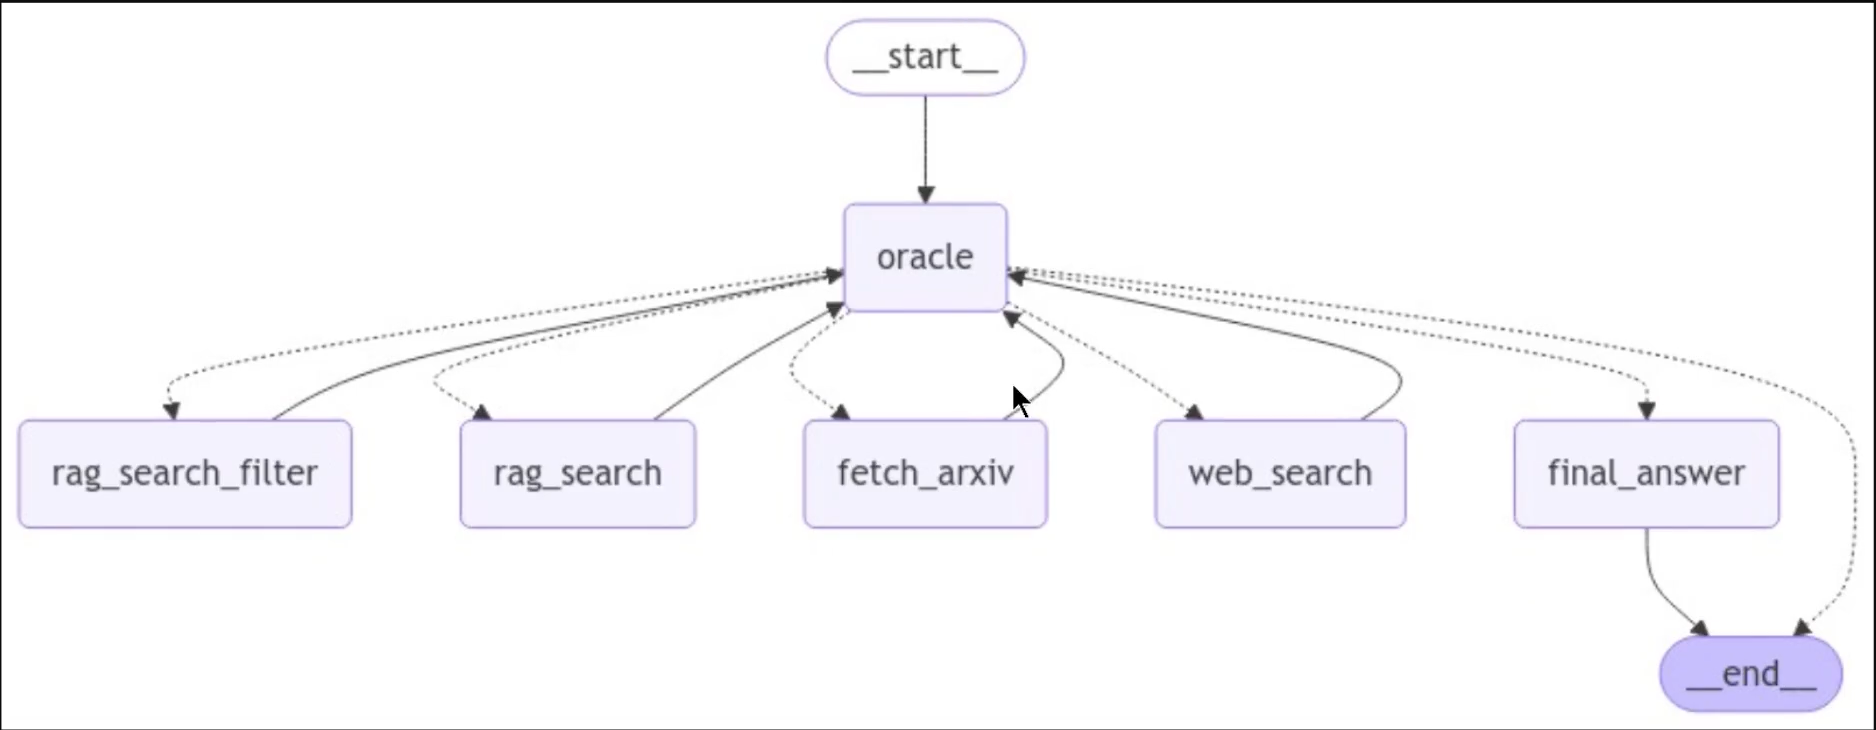

•	Oracle is control node — the agent deciding which subtask to call next.

•	Each box like rag_search_filter, fetch_arxiv, web_search, etc., represents a specialized node (function/agent).

•	Arrows show data flow and decision loops — after each subtask, the flow can return to oracle for the next decision.

•	Finally, everything converges at final_answer → __end__.

#### 1. Implementing the ArXiv Fetch Tool

In [16]:
import requests

# --- specify the arXiv ID of paper to fetch abstract/summary ---
arxiv_id = "1706.03762"  # This ID is for research paper on 'Attention Is All You Need'

# --- make a GET request to retreive the page for the specified paper ---
res = requests.get(f"https://arxiv.org/abs/{arxiv_id}")

# --- Access the content of the response as a string (HTML) ---
res.text

'<!DOCTYPE html>\n<html lang="en">\n\n<head>  <title>[1706.03762] Attention Is All You Need</title>\n  <meta name="viewport" content="width=device-width, initial-scale=1">\n  <link rel="apple-touch-icon" sizes="180x180" href="/static/browse/0.3.4/images/icons/apple-touch-icon.png">\n  <link rel="icon" type="image/png" sizes="32x32" href="/static/browse/0.3.4/images/icons/favicon-32x32.png">\n  <link rel="icon" type="image/png" sizes="16x16" href="/static/browse/0.3.4/images/icons/favicon-16x16.png">\n  <link rel="manifest" href="/static/browse/0.3.4/images/icons/site.webmanifest">\n  <link rel="mask-icon" href="/static/browse/0.3.4/images/icons/safari-pinned-tab.svg" color="#5bbad5">\n  <meta name="msapplication-TileColor" content="#da532c">\n  <meta name="theme-color" content="#ffffff">\n  <link rel="stylesheet" type="text/css" media="screen" href="/static/browse/0.3.4/css/arXiv.css?v=20241206" />\n  <link rel="stylesheet" type="text/css" media="print" href="/static/browse/0.3.4/css/a

In [17]:
# --- Fetch abstract out of the whole HTML Response ---
import re

# Compile a RegEx pattern to find the abstract in the HTML Response
abstract_pattern = re.compile(
    r'<blockquote class="abstract mathjax">\s*<span class="descriptor">Abstract:</span>\s*(.*?)\s*</blockquote>',
    re.DOTALL,
)

# Search for the abstract in the HTML response text
re_match = abstract_pattern.search(res.text)

# Check if the abstract was found and print it; otherwise, display an error message
if re_match:
    print(re_match.group(1))
else:
    print("Abstract not found.")

The dominant sequence transduction models are based on complex recurrent or convolutional neural networks in an encoder-decoder configuration. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, based solely on attention mechanisms, dispensing with recurrence and convolutions entirely. Experiments on two machine translation tasks show these models to be superior in quality while being more parallelizable and requiring significantly less time to train. Our model achieves 28.4 BLEU on the WMT 2014 English-to-German translation task, improving over the existing best results, including ensembles by over 2 BLEU. On the WMT 2014 English-to-French translation task, our model establishes a new single-model state-of-the-art BLEU score of 41.8 after training for 3.5 days on eight GPUs, a small fraction of the training costs of the best models from the literature. We show that the Transforme

#### TOOL - fetch arXiv 

In [3]:
# --- Defining the fetch arxiv tool for agent ---
from langchain_core.tools import tool
import requests
import re

# Compile a RegEx pattern to find the abstract in the HTML Response
abstract_pattern = re.compile(
    r'<blockquote class="abstract mathjax">\s*<span class="descriptor">Abstract:</span>\s*(.*?)\s*</blockquote>',
    re.DOTALL,
)


# Define Tool - 'Fetch Arxiv' for the research agent.
@tool("fetch_arxiv")
def fetch_arxiv(arxiv_id: str) -> str:
    """Fetches the abstract from an ArXiv paper given its ArXiv ID.

    Args:
        arxiv_id (str): The ArXiv paper ID.

    Returns:
        str: The extracted abstract text from the ArXiv paper.
    """

    # --- GET request to retreive all information for the specified paper ---
    res = requests.get(f"https://arxiv.org/abs/{arxiv_id}")

    # --- Search for the abstract in the HTML response text ---
    re_match = abstract_pattern.search(res.text)

    return re_match.group(1) if re_match else "Abstract not found."

In [ ]:
# Testing the above function - on the paper "The Llama 3 Herd of Models https://arxiv.org/abs/2407.21783"

arxiv_id = "2407.21783"
output = fetch_arxiv.invoke(input={"arxiv_id": arxiv_id})
print(output)

Modern artificial intelligence (AI) systems are powered by foundation models. This paper presents a new set of foundation models, called Llama 3. It is a herd of language models that natively support multilinguality, coding, reasoning, and tool usage. Our largest model is a dense Transformer with 405B parameters and a context window of up to 128K tokens. This paper presents an extensive empirical evaluation of Llama 3. We find that Llama 3 delivers comparable quality to leading language models such as GPT-4 on a plethora of tasks. We publicly release Llama 3, including pre-trained and post-trained versions of the 405B parameter language model and our Llama Guard 3 model for input and output safety. The paper also presents the results of experiments in which we integrate image, video, and speech capabilities into Llama 3 via a compositional approach. We observe this approach performs competitively with the state-of-the-art on image, video, and speech recognition tasks. The resulting mod

### TOOL - Web Search with Google SerpAPI

In [18]:
# --- Loading ENV file for API keys ---
import os
from dotenv import load_dotenv, find_dotenv

dotenv_path = find_dotenv()
if not dotenv_path:
    print("ENV file not found")
else:
    load_dotenv(dotenv_path, override=True)
    print("ENV File loaded")

ENV File loaded


In [19]:
# --- Integrating Google SerpAPI for WebSearch ---
from serpapi import GoogleSearch
import os
from getpass import getpass

# --- Setup the SerpAPI request parameters, including the API Key ---
serpapi_key = os.getenv('SERPAPI_KEY') or getpass('SerpAPI key: ')
if not serpapi_key:
    raise ValueError("API Key not found. Recheck your .env file")

serpapi_params = {
    'engine': 'google',  
    'api_key': serpapi_key  # Get the API key securely.
}

# Perform a Google search for the keyword "machine" and limit the results to 5.
search = GoogleSearch({
    **serpapi_params, #dict unpacking
    "q":"machine",
    "num": 5
})

# Extract the main search results from the API Response.
results = search.get_dict().get("organic_results", [])

# Format the search results for readability.
formatted_results = '\n---\n'.join(
    ['\n'.join([x['title'], x['snippet'], x['link']]) for x in results]
)

print(formatted_results)

Machine
A machine is a thermodynamic system that uses power to apply forces and control movement to perform an action. The term is commonly applied to artificial ...
https://en.wikipedia.org/wiki/Machine
---
MACHINE | definition in the Cambridge English Dictionary
a piece of equipment with several moving parts that uses power to do a particular type of work: The different sizes of eggs are sorted by a machine.
https://dictionary.cambridge.org/us/dictionary/english/machine
---
MACHINE Definition & Meaning
The meaning of MACHINE is a mechanically, electrically, or electronically operated device for performing a task. How to use machine in a ...
https://www.merriam-webster.com/dictionary/machine
---
Machine | Definition, Mechanisms & Efficiency
Machine, device, having a unique purpose, that augments or replaces human or animal effort for the accomplishment of physical tasks.
https://www.britannica.com/technology/machine
---
machine
See also: machiné. English. Etymology. Borrowed from Midd

In [20]:
# --- Tool: SerpAPI Google Search --- 
from serpapi import GoogleSearch 

# --- Setup the SerpAPI request parameters, including the API Key ---
serpapi_key = os.getenv('SERPAPI_KEY') or getpass('SerpAPI key: ')
if not serpapi_key:
    raise ValueError("API Key not found. Recheck your .env file")

serpapi_params = {
    'engine': 'google',  
    'api_key': serpapi_key  # Get the API key securely.
}

# Define the 'web_search' tool using the '@tool' decorator. 
@tool('web_search')
def web_search(query: str) -> str:
    """Finds general knowledge information using a Google Search.
    
    Args:
        query(str): The search query string.

    Returns: 
        str: A formatted string of the top search results, including title, snippet, and link. 
    """

    search = GoogleSearch({
        **serpapi_params,
        'q': query,
        'num': 5
    })

    results = search.get_dict().get("organic_results", [])

    formatted_results = '\n---\n'.join(
    ['\n'.join([x['title'], x['snippet'], x['link']]) for x in results])

    return formatted_results if results else "No results found."

In [48]:
# Test the above tool, invoke

output = web_search.invoke(input={"query": "Generative AI"})
print(output)

Generative artificial intelligence
Generative artificial intelligence (Generative AI, GenAI, or GAI) is a subfield of artificial intelligence that uses generative models to produce text, images, ...
https://en.wikipedia.org/wiki/Generative_artificial_intelligence
---
What is Generative AI? | IBM
Generative AI, sometimes called gen AI, is artificial intelligence (AI) that can create original content such as text, images, video, audio or software code ...
https://www.ibm.com/think/topics/generative-ai
---
Generative AI
Generative AI creates new content, like text or images, based on patterns in data. Large Language Models (LLMs) are a powerful form of this AI, generating ...
https://generativeai.net/
---
What is Generative AI? - Gen AI Explained
Generative artificial intelligence (generative AI) is a type of AI that can create new content and ideas, including conversations, stories, images, videos, and ...
https://aws.amazon.com/what-is/generative-ai/
---
What is Generative AI? Examples 

### Creating RAG Tools - rag_search_filter

In [21]:
def format_rag_contexts(matches: list) -> str:
    """Formats the retrieved context matches into a readable string format.

    Args:
        matches (list): A list of matched documents with metadata.

    Returns:
        str: A formatted string of document titles, chunks, and ArXiv IDs.

    """
    formatted_results = []

    # Loop through each match and extract it's metadata
    for x in matches:
        text = (
            f"Title: {x['metadata']['title']}\n"
            f"Chunk: {x['metadata']['chunk']}\n"
            f"ArXiv ID: {x['metadata']['chunk']}\n"
        )

        # Append each formatted string to the results list.
        formatted_results.append(text)

    # Join all the individual formatted strings into one large string.
    return "\n---\n".join(formatted_results)

In [22]:
from langchain_core.tools import tool


@tool("rag_search_filter")
def rag_search_filter(query: str, arxiv_id: str) -> str:
    """Finds information from the ArXiv Database using a Natural Language Query and a specific ArXiv ID.

    Args:
        query(str): The search query in natural language.
        arxiv_id(str): The ArXiv ID of the specific paper to filter by.

    Returns:
        str: A formatted string of relevant document context.
    """

    # Encode the query into a vector representation
    xq = encoder([query])

    # Perform a search on the Pinecone Index, filtering by ArXiv ID.
    xc = index.query(
        vector=xq, top_k=6, include_metadata=True, filter={"arxiv_id": arxiv_id}
    )

    # Format and return the search results. 
    return format_rag_contexts(xc['matches'])

### Creating RAG Tools - rag_search (This performs a broader search)

In [23]:
from langchain_core.tools import tool


@tool("rag_search")
def rag_search(query: str) -> str:
    """Finds information from the ArXiv Database using a Natural Language Query.

    Args:
        query (str) : The search query in natural language.

    Returns:
        str: A formatted string of relevant document context.
    """

    # Encode the query into the vector representation
    xq = encoder([query])

    # Perform a 'BROADER SEARCH' without filtering by ArXiv ID.
    xc = index.query(vector=xq, top_k=5, include_metadata=True)

    # Format and return the search results
    return format_rag_contexts(xc['matches'])

### Final Tool: Answer Generation Tool

In [24]:
# --- Implementing the Final Answer Generation Tool ---

from langchain_core.tools import tool


@tool("final_answer")
def final_answer(
    introduction: str,
    research_steps: str or list,
    main_body: str,
    conclusion: str,
    sources: str or list,
) -> str:
    """Retuns a Natural Language Response in the form of a Research Report.

    Args:
        introduction (str): A short paragraph introducing the user's question and the topic.

        research_steps (str or list): Bullet points or text explaining the steps taken for research.

        main_body (str): The bulk of the answer, 3-4 paragraphs long, providing high-quality information.

        conculusion (str): A short paragraph summarizing the findings.

        sources (str or list): A list or text providing the sources referenced during the research.

    Returns:
        str : A formatted research report string.
    """

    # Format it in bullet pointers if research steps are given as a list. 
    if isinstance(research_steps, list):
        research_steps = "\n".join([f"- {r}" for r in research_steps])
    
    # Format sources if given as a list
    if isinstance(sources, list):
        sources = "\n".join([f"- {s}" for s in sources])
    
    # Construct and return the final research report. 
    return f"{introduction}\n\nResearch Steps:\n{research_steps}\n\nMain Body:\n{main_body}\n\nConclusion:\n{conclusion}\n\nSources\n{sources}"

### Initializing the Oracle LLM - Graph Decision Maker (decides which tool to call and when and save the results and use the last tool 'final answer' for output generation)

In [25]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder


# Define the system prompt guiding the AI's decision-making process.
system_prompt = """You are the Oracle, the great AI decision-maker. 
    Given the user's query, you must decide what to do with it based on the 
    list of tools provided to you.

    If you see that a tool has been used (in the scratchpad) with a particular
    query, DO NOT use that same tool with the same query again. Also, DO NOT use any tool more than twice (i.e., if the tool appears in the scratchpad twice, do not use it again). 

    You should aim to collect information from a diverse range of sources before
    providing the answer to the user. Once you have colleccted plenty of information
    to answer the user's question (stored in the scratchpad), use the final_answer tool.
    """

# Create a prompt template for the conversation flow.
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),  # Define the AI's role and rules.
        # Insert past chat messages to maintain context.
        MessagesPlaceholder(variable_name="chat_history"),
        # Insert user's input dynamically.
        ("user", "{input}"),
        # Include the assistant's scratchpad to track tool usage and intermediate steps.
        ("assistant", "sratchpad: {scratchpad}"),
    ]
)

In [35]:
from langchain_core.messages import ToolCall, ToolMessage
from langchain_openai import ChatOpenAI
import os

# Initialize the OpenAI language model with specific settings.
llm = ChatOpenAI(
    model='gpt-4o',
    openai_api_key=os.environ['OPENAI_API_KEY'],
    temperature=0
)

# Define the list of tools available to the oracle.
tools = [
    rag_search_filter,
    rag_search,
    fetch_arxiv,
    web_search,
    final_answer
]

# Function to create the scratchpad from the intermediate tool calls.
def create_scratchpad(intermediate_steps: list[ToolCall]) -> str:
    """Takes intermediate_steps and transforms them into a readable log.
    Arg:
        intermediate_steps: List of ToolCall object which represents the steps taken by the Oracle during the decision making process. We format this information into a scratchpad which helps Oracle LLM to avoid using the same tool usage or queries.
    """
    research_steps = []
    
    # Loop over each step and process tool calls with actual outputs.
    for i, action in enumerate(intermediate_steps):
        if action.log != 'TBD': # only loggging the tools which has taken action
            research_steps.append(
                f'Tool: {action.tool}, input: {action.tool_input}\n'
                f'Output: {action.log}'
            )
    
    # Join the research steps into a readable log.
    return '\n---\n'.join(research_steps)

# Define the oracle's decision-making pipeline.
oracle = (
    {
        'input': lambda x: x['input'],
        'chat_history': lambda x: x['chat_history'],
        'scratchpad': lambda x: create_scratchpad(intermediate_steps=x['intermediate_steps']),
    }
    | prompt
    | llm.bind_tools(tools, tool_choice='any')
)

### Testing the Oracle and the Tools Working

In [40]:
#input = "Tell me something interesting about dynamic bactracking AI and LLMs"
#input = "Who won the Super Bowl 2024?"
input = "What is the Arxiv paper with the ID 2407.21783 all about?"

inputs = {
    "input": input,
    "chat_history": [],
    "intermediate_steps": [],
}

# Invoke the oracle with input, processing the query and returning a response
out = oracle.invoke(inputs)

# Display the Oracle's response
print(out)

content='' additional_kwargs={'tool_calls': [{'id': 'call_gmpZ3AaYsLgStTw2k4AmSZ2Y', 'function': {'arguments': '{"arxiv_id":"2407.21783"}', 'name': 'fetch_arxiv'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 610, 'total_tokens': 631, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_b1442291a8', 'id': 'chatcmpl-CZXCd0B8n6LVrZ3iPX81xVBxCcKlX', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--84463776-1c85-4a07-b51d-26683a90588a-0' tool_calls=[{'name': 'fetch_arxiv', 'args': {'arxiv_id': '2407.21783'}, 'id': 'call_gmpZ3AaYsLgStTw2k4AmSZ2Y', 'type': 'tool_call'}] usage_metadata={'input_tokens': 610, 'output_tokens': 21, 'total_tokens': 631, 'input_token_details': {'audi

In [41]:
# Checking the tools Oracle Decision Maker used for my first input 

# input = "Tell me something interesting about dynamic bactracking AI and LLMs"
# out.tool_calls[0] #-> 0 indicates the first tool it uses for input
"""Output: {'name': 'rag_search', 'args': {'query': 'dynamic backtracking AI'}}"""

# input = "Who won the Super Bowl 2024?"
#out.tool_calls[0] #-> 0 indicates the first tool it uses for input
"""Output: {'name': 'web_search', 'args': {'query': 'Super Bowl 2024 winner'}}"""

# input = "What is the Arxiv paper with the ID 2407.21783 all about?"
out.tool_calls[0] #-> 0 indicates the first tool it uses for input


{'name': 'fetch_arxiv',
 'args': {'arxiv_id': '2407.21783'},
 'id': 'call_gmpZ3AaYsLgStTw2k4AmSZ2Y',
 'type': 'tool_call'}